In [1]:
import pandas as pd
import json
import itertools
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
%matplotlib inline

### Leitura do arquivo

No Firebase os dados encontram-se ordenados como estruturas aninhadas. Vamos usar a função Export JSON no Firebase console.

<img src=firebase_object_tree.png width=200>


A função *Exportar o JSON* fica à direita na visão de base de dados:
<img src=export_json.png width=500>

In [2]:
arquivo = open("teste-ab-export.json")
linhas = arquivo.readlines()
texto = "".join(linhas)
dados_fire = json.loads(texto)

### Análise do atributo logs

 Veja que log, que contém todos os dados, está pesadamente aninhado

In [3]:
for k,v in dados_fire["logs"].items():
    # print(k,v) # habilite para imprimir as chaves de mais alto nível
    for chave, valor in v.items():
        # print(chave, valor) # habilite para imprimir as chaves inferiores
        pass # desabilite quando reabilitar a linha de cima



### Convertendo para um dataframe

O pandas entende listas de dicionários que têm as mesmas chaves. O Firebase nos dá dicionários de dicionários de dicionários. 

Vamos precisar converter. Basta inserir todos os itens que estavam na chave "logs" em uma lista

In [4]:
lista_dicionarios = []

for k,v in dados_fire["logs"].items():
    lista_dicionarios.append(v)

        


A função `from_records` converte a lista de dicionários em um dataframe

In [5]:
dataframe = pd.DataFrame.from_records(lista_dicionarios)

Desta forma temos o dataframe. Observe que os eventos são dos seguintes tipos:

* *inicio* - quando um usuário inicia uma tarefa
* final - quando o usuário termina uma tarefa

Precisamos agrupar pelo `id` do usuário e depois subtrair o tempo inicial do final, para sabermos quanto tempo efetivamente levou aquela tarefa

In [6]:
dataframe

,tempo,tipo,user_id,versao
0,1478529819356,inicio,2506455801,B
1,1478518887954,final,3534175994,B
2,1478609993249,inicio,1857098293,A
3,1478536052209,final,1213412462,B
4,1478560818571,inicio,4152027044,B
5,1478547808925,inicio,984025379,A
6,1478538273229,final,3029084152,A
7,1478560865309,inicio,4152027044,B
8,1478519223816,inicio,514803398,A
9,1478519399919,inicio,3724356519,B


### Convertendo para um DataFrame de delta_t

In [7]:
agrupado = dataframe.groupby(by=["user_id", "versao"])

In [8]:
users = set(dataframe.user_id) # We convert it to a set so that each user appear only once

In [9]:
users = list(users) 

In [10]:
resultados = []

for u in users:
    for versao in ["A", "B"]:
        if (u, versao) in agrupado.groups.keys(): # Check if a specific pair user/type of test happened
            grupo1 =  agrupado.get_group((u, versao))
            grupo1 = grupo1.sort_values(by="tempo") # Para evitar que inícios sem fim gerem tempos negativos
            
            if len(grupo1[grupo1.tipo=="final"])>= 1 and len(grupo1[grupo1.tipo=="inicio"]) >= 1:
                delta_t = grupo1[grupo1.tipo=="final"].iloc[-1].tempo - grupo1[grupo1.tipo=="inicio"].iloc[0].tempo
                resultados.append({"user_id":u, "delta_t":delta_t, "versao":versao})

In [11]:
grupo1.sort_values(by="tempo")

,tempo,tipo,user_id,versao
40,1478544828909,inicio,2696156667,B
104,1478544864747,inicio,2696156667,B
27,1478544900181,final,2696156667,B


In [12]:
dataframe_resumo = pd.DataFrame.from_records(resultados)

In [13]:
dataframe_resumo.delta_t/=1000 # Convertendo milissegundos em segundos

In [14]:
dataframe_resumo

,delta_t,user_id,versao
0,41.311,1561760900,A
1,13.297,116148368,A
2,24.232,2754007705,B
3,7.509,984025379,A
4,20.961,1585826857,A
5,75.802,1857098293,A
6,10.151,1528978230,B
7,6.957,1212005310,A
8,19.823,190964928,B
9,11.625,3237228231,A


# Teste de hipotese

In [16]:
tempos_A = list(dataframe_resumo[dataframe_resumo.versao=="A"].delta_t)
tempos_B = list(dataframe_resumo[dataframe_resumo.versao=="B"].delta_t)
tempos_ma= []
tempos_mb = []

for i in tempos_A:
    if i< 100:
        tempos_ma.append(i)
for i in tempos_B:
    if i< 100:
        tempos_mb.append(i)

del tempos_ma[-1]
tempos_A = list(tempos_ma)
tempos_B = list(tempos_mb)

queremos ver se o tempo medio da versão B é menor que a versão A, assim:

hipótese nula: B=>A

hipótese alternativa: B<A

(array([ 4.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([  6.957 ,  13.8415,  20.726 ,  27.6105,  34.495 ,  41.3795,
         48.264 ,  55.1485,  62.033 ,  68.9175,  75.802 ]),
 <a list of 10 Patch objects>)

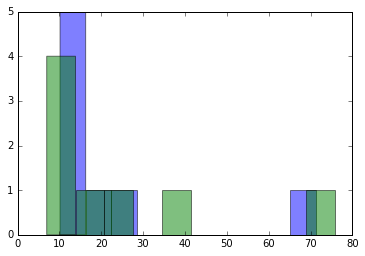

In [18]:
plt.hist(tempos_B,alpha=0.5,bins =10)
plt.hist(tempos_A,alpha=0.5,bins =10)

In [19]:
media_b = np.mean(tempos_B)
n = len(tempos_B)

media_a = np.mean(tempos_A)


cov_ab = np.cov(tempos_A,tempos_B)[0][1] # calcula a covariancia, numpy retorna uma matriz,a linha 0,coluna 1 contem a covariancia de a,b
var_ab = media_a + media_b+ 2*cov_ab # nos queremos a variancia de a+b, certo?
dp_ab = var_ab*0.5 # desvio padrão

#média padronizada com o desvio padrão amostral.
Z = (media_b - media_a)/(dp_ab/(n**0.5))

#distribuição t-student com (n-1) graus de liberdade,unicaldal a esquerda,acho que essa parte esta errada
valor_p =(1-scipy.stats.t.cdf(Z, df=(n-1)))
    
alfa = 0.05 #nivel de siginificancia de 5%

if valor_p<alfa:
    print('nos não podemos rejeitar a hipotese nula pois ',alfa,'<',valor_p,'com grau confiança de 95%')
else:
    print('podemos rejeitar a hipotese nula pois ',alfa,'>=',valor_p,'com grau confiança de 95%')

podemos rejeitar a hipotese nula pois  0.05 >= 0.41510487337 com grau confiança de 95%
